In [81]:
import sys
from typing import Tuple


import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from solution_1 import get_grid
from solution_1 import bfs_spiral_add_number_to_grid
from solution_1 import LIST_CYCLE_POSITION_SHIFT
from solution_1 import Grid
from solution_2 import bfs_spiral_add_number_to_grid_inpendent_of_grid


np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(linewidth=sys.maxsize)

In [82]:
def display_solution(matrix, figsize=(10,10)):
    # Get the shape of the matrix
    num_rows, num_cols = matrix.shape

    # Create a meshgrid for X and Y
    np_array_x = np.arange(0, num_cols, 1)
    np_array_y = np.arange(0, num_rows, 1)
    np_array_2d_x, np_array_2d_y = np.meshgrid(np_array_x, np_array_y)

    # Create a 3D plot
    figure_1 = plt.figure(figsize=figsize)
    axes_1 = figure_1.add_subplot(111, projection='3d')

    # Add labels
    axes_1.set_xlabel('X-axis')
    axes_1.set_ylabel('Y-axis')
    axes_1.set_zlabel('Height')

    # Plot the 3D surface
    axes_1.plot_surface(np_array_2d_x, np_array_2d_y, matrix, cmap='viridis')
    
    ####################
    
    figure_2 = plt.figure(figsize=figsize)
    axes_2 = figure_2.add_subplot(111)
    
    image = axes_2.imshow(matrix, cmap='viridis', origin='lower')
    colorbar = figure_2.colorbar(image, ax=axes_2)  # Add colorbar to the subplot

    axes_2.set_title('Height Matrix')
    axes_2.set_xlabel('X-axis')
    axes_2.set_ylabel('Y-axis')
    
    ####################
    
    # Calculate the gradient using np.gradient
    gradient_y, gradient_x = np.gradient(matrix)

    # Create a vector field
    vector_field_x = -gradient_x
    vector_field_y = -gradient_y
    
    figure_3 = plt.figure(figsize=figsize)
    axes_3 = figure_3.add_subplot(111)

    axes_3.quiver(vector_field_x, vector_field_y, scale=20, scale_units='xy', angles='xy')
    axes_3.set_title('Vector Field (Gradient)')
    axes_3.set_xlabel('X-axis')
    axes_3.set_ylabel('Y-axis')

        

# Initial data

In [83]:
list_cycle_position_shift = LIST_CYCLE_POSITION_SHIFT

grid_size_x = 50
grid_size_y = 50

position_start: Tuple[int, int] = (30, 20)


# Solution 1

In [84]:
grid_1 = get_grid(grid_size_x, grid_size_y)

bfs_spiral_add_number_to_grid(grid_1, position_start, list_cycle_position_shift)

matrix_1 = np.array(grid_1)
matrix_1

array([[2500, 2450, 2352, 2256, 2162, 2070, 1980, 1892, 1806, 1722, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1608, 1609, 1610, 1611, 1612, 1613, 1614, 1615, 1616, 1617, 1618, 1619, 1620, 1621, 1622, 1623, 1624, 1625, 1626, 1627, 1628, 1629, 1630, 1631, 1632, 1633, 1634, 1635, 1636, 1637, 1638, 1639, 1640],
       [2499, 2449, 2351, 2255, 2161, 2069, 1979, 1891, 1805, 1721, 1600, 1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1491, 1492, 1493, 1494, 1495, 1496, 1497, 1498, 1499, 1500, 1501, 1502, 1503, 1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521],
       [2498, 2448, 2350, 2254, 2160, 2068, 1978, 1890, 1804, 1720, 1599, 1482, 1333, 1334, 1335, 1336, 1337, 1338, 1339, 1340, 1341, 1342, 1343, 1344, 1345, 1346, 1347, 1348, 1349, 1350, 1351, 1352, 1353, 1354, 1355, 1356, 1357, 1358, 1359, 1360, 1361, 1362, 1363, 1364, 1365, 1366, 1367, 1368, 1369, 1370],
       [2497, 2447, 2349, 2253, 2159, 2067, 1977, 1889, 1803, 1719, 1598,

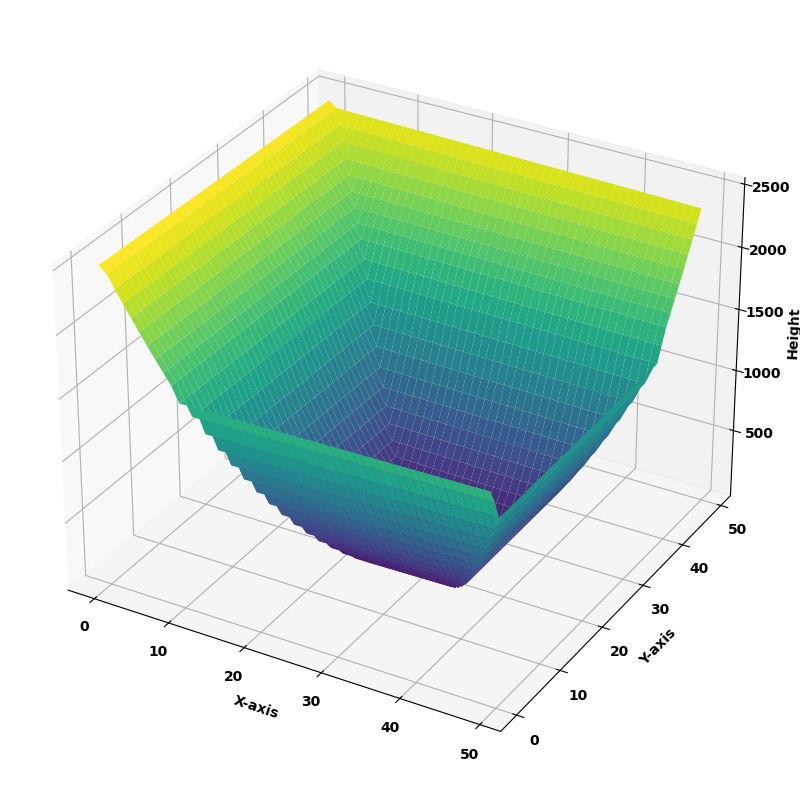

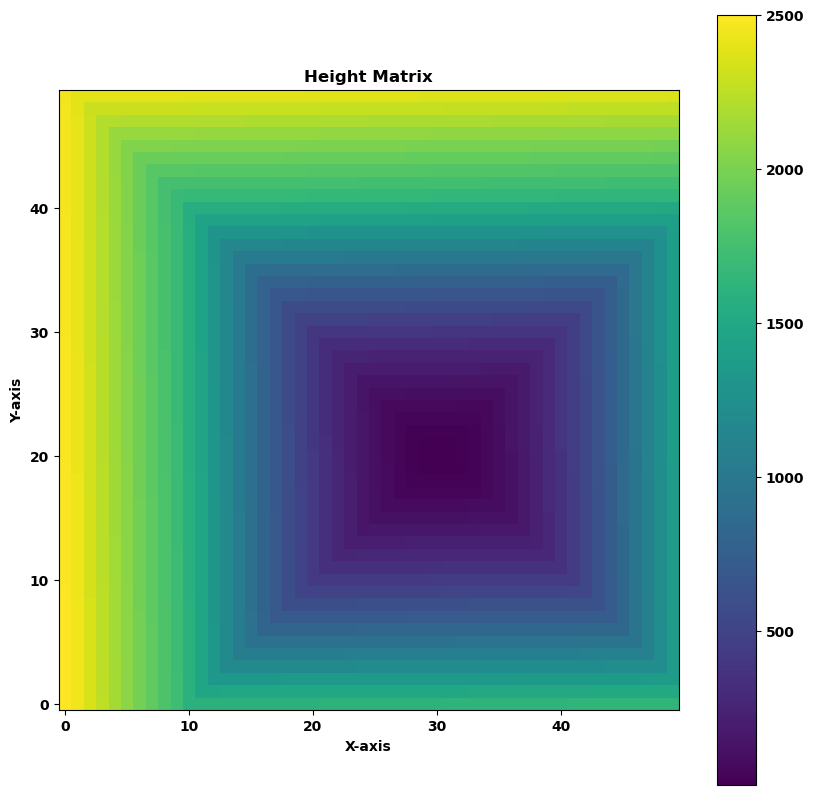

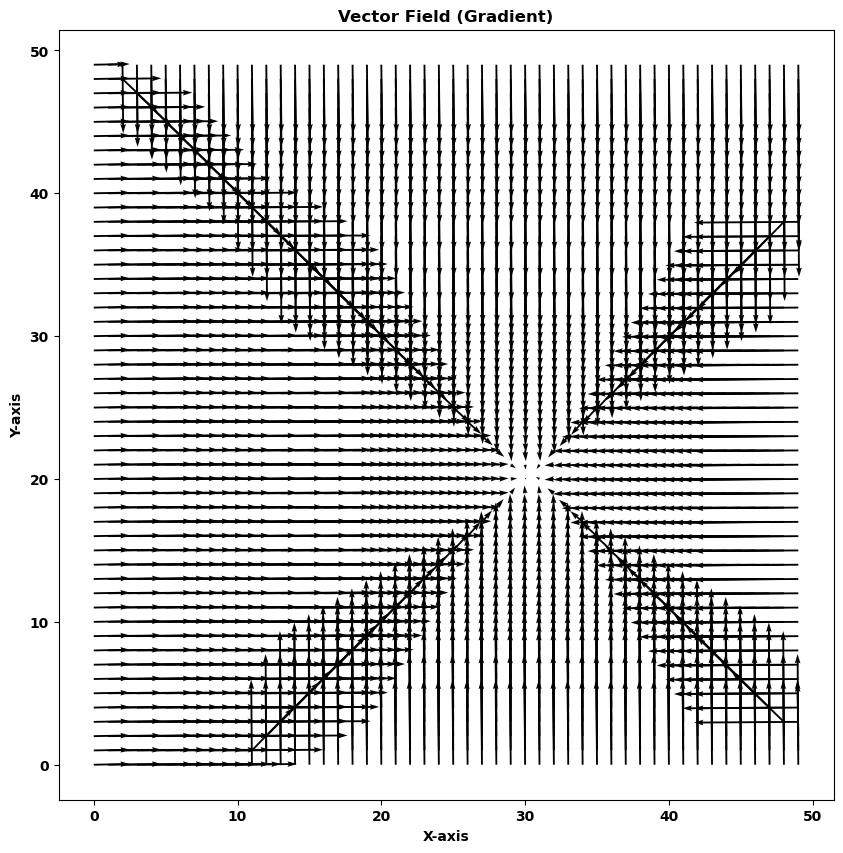

In [85]:
display_solution(matrix_1)

# Solution 2

In [86]:
grid_2 = get_grid(grid_size_x, grid_size_y)

number_of_valid_positions_on_grid = grid_size_x * grid_size_y

bfs_spiral_add_number_to_grid_inpendent_of_grid(grid_2, number_of_valid_positions_on_grid, position_start)

matrix_2 = np.array(grid_2)
matrix_2

array([[3651, 3414, 3185, 2964, 2751, 2546, 2349, 2160, 1979, 1806, 1641, 1642, 1643, 1644, 1645, 1646, 1647, 1648, 1649, 1650, 1651, 1652, 1653, 1654, 1655, 1656, 1657, 1658, 1659, 1660, 1661, 1662, 1663, 1664, 1665, 1666, 1667, 1668, 1669, 1670, 1671, 1672, 1673, 1674, 1675, 1676, 1677, 1678, 1679, 1680],
       [3650, 3413, 3184, 2963, 2750, 2545, 2348, 2159, 1978, 1805, 1640, 1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1491, 1492, 1493, 1494, 1495, 1496, 1497, 1498, 1499, 1500, 1501, 1502, 1503, 1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521],
       [3649, 3412, 3183, 2962, 2749, 2544, 2347, 2158, 1977, 1804, 1639, 1482, 1333, 1334, 1335, 1336, 1337, 1338, 1339, 1340, 1341, 1342, 1343, 1344, 1345, 1346, 1347, 1348, 1349, 1350, 1351, 1352, 1353, 1354, 1355, 1356, 1357, 1358, 1359, 1360, 1361, 1362, 1363, 1364, 1365, 1366, 1367, 1368, 1369, 1370],
       [3648, 3411, 3182, 2961, 2748, 2543, 2346, 2157, 1976, 1803, 1638,

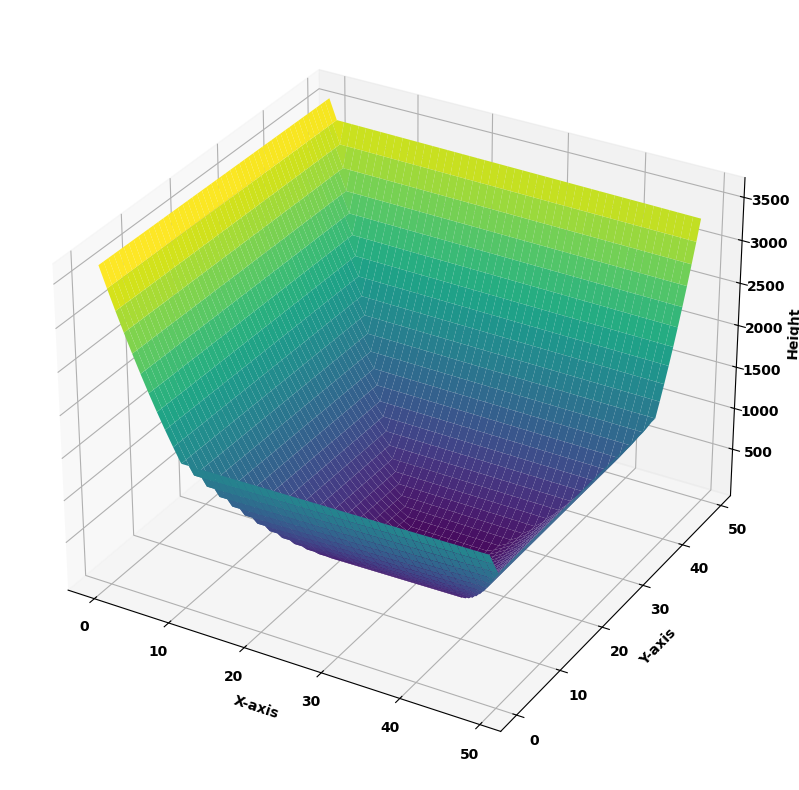

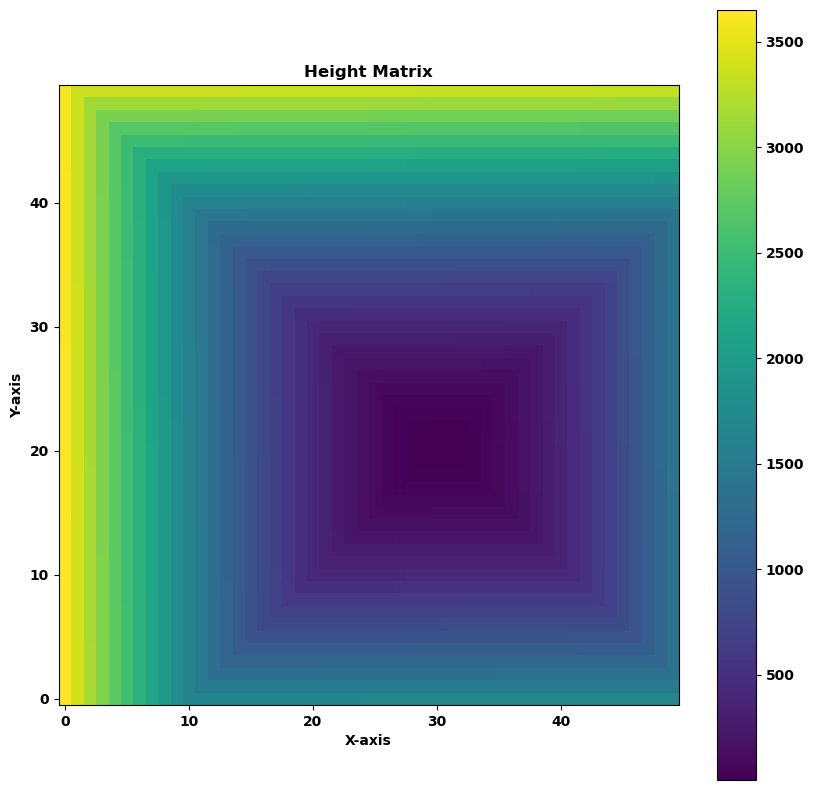

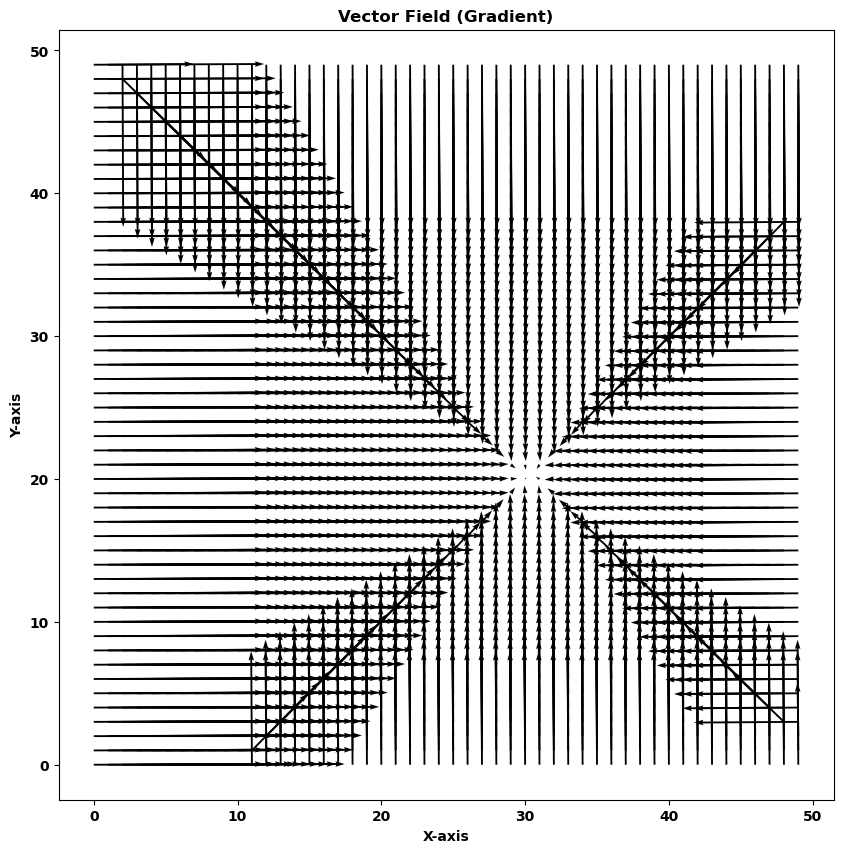

In [87]:
display_solution(matrix_2)